In [9]:
import torch
from transformers import BlipProcessor, BlipForQuestionAnswering
from PIL import Image
from datasets import load_dataset
import evaluate
import matplotlib.pyplot as plt

# 1. Device Configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# 2. Load Processor and Model
print("Loading BLIP model and processor...")
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

# 3. Load Custom Checkpoint
checkpoint_path = "BLIP_Augument.pt"
try:
    state_dict = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(state_dict)
    print(f"Loaded checkpoint: {checkpoint_path}")
except FileNotFoundError:
    print(f"Warning: '{checkpoint_path}' not found. Using base weights.")

model.to(device)
model.eval()

# 4. Load Dataset
print("Loading SLAKE dataset...")
dataset = load_dataset("mdwiratathya/SLAKE-vqa-english")
eval_split = dataset["validation"]

# 5. Load Metrics
print("Loading metrics...")
bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")

print("Setup Complete. Ready for interactive cells.")

Device: cuda
Loading BLIP model and processor...
Loaded checkpoint: BLIP_Augument.pt
Loading SLAKE dataset...
Loading metrics...
Setup Complete. Ready for interactive cells.


Enter image index (0 - 1052):  5


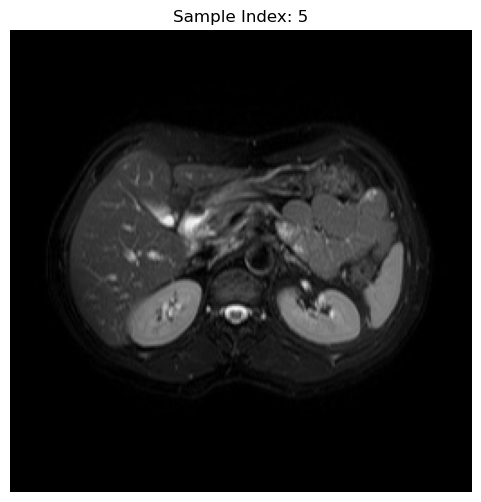

Image loaded. Original Question: Does the picture contain liver?
Run the next cell to ask a question.


In [11]:
# @title Step 1: Select Image by Index

# 1. User Input for Index
try:
    max_idx = len(eval_split) - 1
    index_input = input(f"Enter image index (0 - {max_idx}): ")
    idx = int(index_input)

    if 0 <= idx <= max_idx:
        # Load sample
        current_sample = eval_split[idx]
        current_image = current_sample["image"]
        
        # 2. Visualize Image
        plt.figure(figsize=(6, 6))
        plt.imshow(current_image)
        plt.axis('off')
        plt.title(f"Sample Index: {idx}")
        plt.show()
        
        print(f"Image loaded. Original Question: {current_sample['question']}")
        print("Run the next cell to ask a question.")
    else:
        print(f"Error: Index must be between 0 and {max_idx}.")

except ValueError:
    print("Error: Please enter a valid integer.")

In [15]:
# @title Step 2: Inference & Evaluation

if 'current_sample' not in locals():
    print("Error: Please run the Image Selection cell first.")
else:
    # 1. User Input for Question
    default_question = current_sample['question']
    ref_answer = current_sample["answer"]
    
    print(f"Original Question: {default_question}")
    user_question = input("Enter your question (Press Enter to use Original): ")

    # Use original question if user input is empty
    final_question = user_question if user_question.strip() else default_question
    print(f"\nProcessing Question: {final_question}")

    # 2. Model Inference
    inputs = processor(current_sample["image"], final_question, return_tensors="pt").to(device)

    with torch.no_grad():
        out = model.generate(**inputs, max_new_tokens=20)
        pred_answer = processor.decode(out[0], skip_special_tokens=True).strip()

    # 3. Calculate Metrics (Single Sample)
    # Note: BLEU/ROUGE expect lists of references and predictions
    bleu_result = bleu_metric.compute(predictions=[pred_answer], references=[[ref_answer]])
    rouge_result = rouge_metric.compute(predictions=[pred_answer], references=[[ref_answer]])
    
    # Check Exact Match
    is_exact_match = pred_answer.lower() == ref_answer.lower()

    # 4. Display Results
    print("-" * 40)
    print(f"🖼️  Image Index:    {idx}")
    print(f"❓  Question:       {final_question}")
    print("-" * 40)
    print(f"🤖  Model Prediction:  {pred_answer}")
    print(f"✅  Ground Truth:      {ref_answer}")
    print("-" * 40)
    
    print("📊  Evaluation Metrics (For this sample):")
    print(f"   • Exact Match: {'YES' if is_exact_match else 'NO'}")
    print(f"   • BLEU Score:  {bleu_result['bleu']:.4f}")
    print(f"   • ROUGE-L:     {rouge_result['rougeL']:.4f}")
    
    if user_question.strip() and user_question != default_question:
        print("\n*Note: You used a custom question. The Ground Truth and Metrics are compared against the dataset's original answer.")

Original Question: Does the picture contain liver?


Enter your question (Press Enter to use Original):  Is liver contained in this picture?



Processing Question: Is liver contained in this picture?
----------------------------------------
🖼️  Image Index:    5
❓  Question:       Is liver contained in this picture?
----------------------------------------
🤖  Model Prediction:  yes
✅  Ground Truth:      Yes
----------------------------------------
📊  Evaluation Metrics (For this sample):
   • Exact Match: YES
   • BLEU Score:  0.0000
   • ROUGE-L:     1.0000

*Note: You used a custom question. The Ground Truth and Metrics are compared against the dataset's original answer.
